In [3]:
import sys
sys.path.append("../src")

import logging
from pathlib import Path
import numpy as np
import torch
from torch import nn
from matplotlib import pyplot as plt
from dataset.data_loading import BasicDataset
from dataset.dataset_interface import DatasetInterface
from networks.UNet.unet_model import UNet
import open3d as o3d
from utils.visualization_utils import visualize_depth, to_rgb
from utils.transformation_utils import imgs_to_pcd, rs_ci
import yaml

root_path = Path("../")

class Args:
    model_dir = root_path / "resources/models/1645177007.6430748/M_total"
    input_augmented = root_path / "resources/images/calibrated_masked_augmented/cropped/ycb_video/test_dataset.json"
    input_not_augmented = root_path / "resources/images/calibrated_masked/cropped/ycb_video/test_dataset.json"
    input_augmented_not_cropped = root_path / "resources/images/calibrated_masked_augmented/not-cropped/ycb_video/test_dataset.json"
    input_not_augmented_not_cropped = root_path / "resources/images/calibrated_masked/not-cropped/ycb_video/test_dataset.json"

args = Args()

config_path = args.model_dir.parent / "config.yml"
model = sorted(args.model_dir.glob("*.pth"))[-1]
with open(config_path) as f:
    config = yaml.safe_load(f)

network_config = config['network_config']
trainer_config = config['basic_trainer']
dataset_config = config['dataset_config']

is_augmented = 'augmented' in trainer_config['train_path']
is_cropped = 'not-cropped' not in trainer_config['train_path']
if is_augmented:
    if is_cropped:
        files = DatasetInterface.get_files_by_path(args.input_augmented)
    else:
        files = DatasetInterface.get_files_by_path(args.input_augmented_not_cropped)
else:
    if is_cropped:
        files = DatasetInterface.get_files_by_path(args.input_not_augmented)
    else:
        files = DatasetInterface.get_files_by_path(args.input_not_augmented_not_cropped)

net = UNet(n_input_channels=6, n_output_channels=1, initial_channels=network_config['initial_channels'])


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
logging.info(f'Loading model {model}')
logging.info(f'Using device {device}')

net.to(device=device)
net.load_state_dict(torch.load(model, map_location=device))
# fixes wrongly saved weights from data parallel
# tmp_net = nn.DataParallel(net)
# tmp_net.load_state_dict(torch.load(model, map_location=device))
# model.unlink()
# torch.save(tmp_net.module.state_dict(), model)
# net.load_state_dict(torch.load(model, map_location=device))
# net.eval()

logging.info('Model loaded!')

if dataset_config['normalize_depths']:
    depth_norm, depth_unnorm = BasicDataset.compute_depth_bounds_normalization(files)


INFO - 2022-02-18 19:53:23,952 - 2720650289 - Loading model ../resources/models/1645177007.6430748/M_total/e4.pth
INFO - 2022-02-18 19:53:23,953 - 2720650289 - Using device cpu
INFO - 2022-02-18 19:53:23,966 - 2720650289 - Model loaded!
computing depth bounds for normalization: 100%|██████████| 51/51 [00:10<00:00,  5.00it/s]

computed normalization bounds: min 0.0, max 2772.0


INFO - 2022-02-18 20:08:53,623 - 2413773443 - 
Predicting image /home/kit/anthropomatik/ng3916/self-supervised-depth-denoising/resources/images/calibrated_masked/not-cropped/ycb_video/10022022/1644490352.203337.npz ...


0.36165142 38711.043
Mean depths: Input 647.8311468271997Label 787.3775024414062 Predicted 0.36165139079093933
[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.
[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.
[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


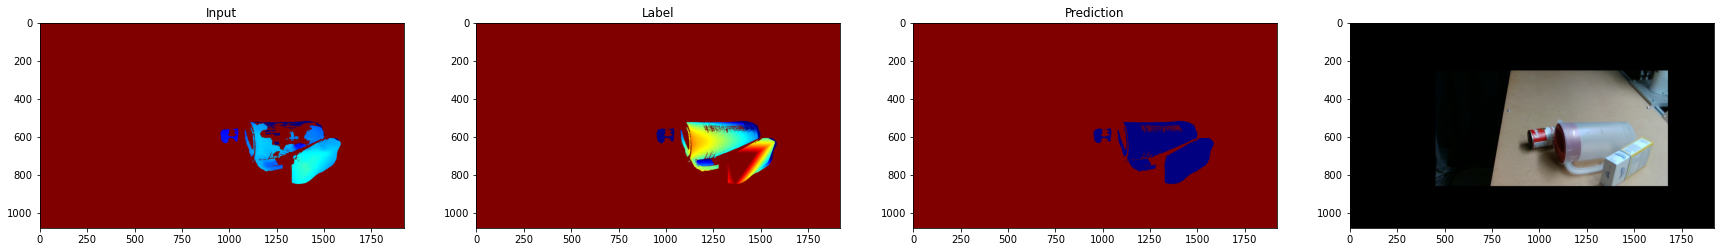

In [5]:
idx = np.random.randint(len(files), size=1).item()
rs_rgb, rs_depth, zv_rgb, zv_depth, mask = DatasetInterface.load(files[idx])

logging.info(f'\nPredicting image {files[idx]} ...')

rs_min = np.nanmin(rs_depth)
rs_max = np.nanmax(rs_depth)

set = BasicDataset.preprocess_set(
    rs_rgb, 
    rs_depth, 
    mask, 
    zv_depth, 
    dataset_config=BasicDataset.Config(
        scale=dataset_config['scale_images'], 
        add_nan_mask_to_input=dataset_config['add_nan_mask_to_input'], 
        add_region_mask_to_input=dataset_config['add_region_mask_to_input'], 
        normalize_depths=dataset_config['normalize_depths'],
    ),
    depth_normalization=depth_norm
)

img = set['image'].unsqueeze(0)
nan_mask = set['nan-mask'] 
region_mask = set['region-mask']
img = img.to(device=device, dtype=torch.float32)

with torch.no_grad():
    pred_depths = net(img)
    pred_depth = pred_depths.squeeze().float().cpu().detach().numpy()

# undo normalization
if dataset_config['normalize_depths']:
    pred_depth = depth_unnorm(pred_depth)

input_rgb = BasicDataset.resize(rs_rgb, dataset_config['scale_images'])
input_depth = BasicDataset.resize(rs_depth, dataset_config['scale_images'])
real_depth = BasicDataset.resize(zv_depth, dataset_config['scale_images'])

# blackout pixel not in mask
print(np.nanmin(pred_depth), np.nanmax(pred_depth))
mask = np.logical_and(nan_mask, region_mask)[0]
pred_depth = np.where(mask, pred_depth, np.nan)
input_depth = np.where(mask, input_depth, np.nan)
real_depth = np.where(mask, real_depth, np.nan)

output_rgb = BasicDataset.resize(zv_rgb, dataset_config['scale_images'])
output_pcd = imgs_to_pcd(output_rgb, real_depth, rs_ci)

print(f"Mean depths: Input {np.nanmean(input_depth)}\
Label {np.nanmean(real_depth)} Predicted {np.nanmean(pred_depth)}")

pred_pcd = imgs_to_pcd(input_rgb, pred_depth, rs_ci)
input_pcd = imgs_to_pcd(input_rgb, input_depth.astype(np.float32), rs_ci)
o3d.visualization.draw_geometries([input_pcd])
o3d.visualization.draw_geometries([output_pcd])
o3d.visualization.draw_geometries([pred_pcd])

_, axarr = plt.subplots(1, 4, figsize=(30, 10))
axarr[0].title.set_text("Input")
axarr[0].imshow(visualize_depth(input_depth))
axarr[1].title.set_text("Label")
axarr[1].imshow(visualize_depth(real_depth))
axarr[2].title.set_text("Prediction")
axarr[2].imshow(visualize_depth(pred_depth))
axarr[3].imshow(to_rgb(rs_rgb))